In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tools
import constants

0.00014746639368170598 21.000000000000018
21.480000000000018


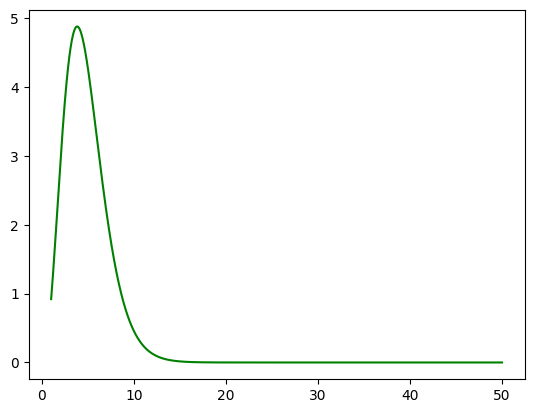

In [4]:
# test fonction intégrale

def fonction(x) :
    num = np.exp(x)*(x**4)
    denom = (np.exp(x) -1 )**2
    return num/denom

temp_test = np.arange(1, 50, 1e-2)

plt.figure()
plt.plot(temp_test, fonction(temp_test), "-g")

def zero(x, y, eps=1e-4) :
    i = 0
    for i in range(0, len(y)) :
        if y[i] < eps :
            return x[i]

print(fonction(temp_test)[2000], temp_test[2000])
print(zero(temp_test, fonction(temp_test)))

In [17]:
def fonction_debye(temperature, temp_debye) :
    alpha = 1/temperature
    return fonction(alpha*temp_debye)
    

In [6]:
def integrate_between_bounds(x, y, a, b):
    # Select indices where x is within [a, b]
    mask = (x >= a) & (x <= b)
    x_selected = x[mask]
    y_selected = y[mask]
    # Use the trapezoidal rule for integration
    return np.trapz(y_selected, x_selected)

In [ ]:
# For T=20K

def progressive_integration(x,y) :
    integration = [] 
    for val in x :
        aire = integrate_between_bounds(x, y, 0, val)
        integration.append(aire)
    return integration

def debye_integral(temperature) :
    debye_temperature = np.arange(0.1, 700, 0.1)
    y = fonction_debye(temperature, debye_temperature)
    integral = progressive_integration(debye_temperature, y)
    return debye_temperature, integral

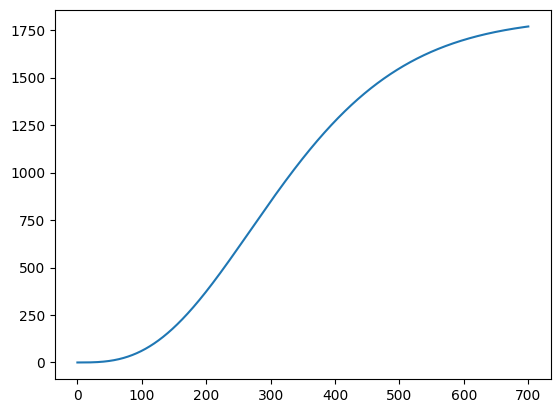

In [24]:
test = debye_integral(70)
debye_temperature = np.arange(0.1, 700, 0.1)

plt.figure()
plt.plot(test[0], test[1])